### Notebook to plot BOWTIE SeaSnake data.

Data is one-minute frequency.

James Ruppert
jruppert@ou.edu
8/29/24

### Main settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import subprocess, cmocean
import pandas as pd
import xarray as xr
import seaborn as sns
from bowtie_read_data import *
from scipy import signal
from time_series_diag import *

#### Read data

In [2]:
# SeaSnake data
snakedat = read_bowtie_seasnake()
# DSHIP data
dship = read_bowtie_dship()

---
### Plotting routines

#### Plot functions

In [3]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
# sns.set_theme(style="dark")

In [4]:
def do_smooth(invar, nt_smooth=10):
    invar_df = pd.DataFrame(invar)
    return invar_df.rolling(window=nt_smooth, center=True, closed='both', min_periods=3).mean()

In [5]:
def dailyavg(invar_0, times_invar_0):

    invar = np.array(invar_0)
    times_invar = np.array(times_invar_0)
 
    # Use timedeltas to determine N steps per day (npd)
    # ...being sure to use consistent timedelta units, i.e., [ns]
    h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
    dt = (times_invar[1] - times_invar[0]).astype('timedelta64[ns]')
    npd = int(np.round(h24 / dt))

    # Create new daily time array with values at day midpoint
    # h12 = np.timedelta64(12, 'h')
    # times_daily_12h = np.arange(times_invar[0]+h12, times_invar[-1]+h12, h24)
    # times_daily_00h = np.arange(times_invar[0], times_invar[-1], h24)
    
    # nd = int(times_invar.size/npd)

    # Simply interpolation to mid-point of day
    # invar_daily2 = np.interp(times_daily_12h.astype(np.float64), times_invar.astype(np.float64), invar)

    # Daily average
    # invar_daily1 = np.full(nd, np.nan)
    # for iday in range(nd):
    #     ind_avg = np.where((times_invar >= times_daily_00h[iday]) & (times_invar < times_daily_00h[iday]+h24))
    #     invar_daily1[iday] = np.nanmean(invar[ind_avg])

    # ROLLING AVERAGE WITH A COSINE WINDOW
    invar_df = pd.DataFrame(invar)
    # invar_daily3 = invar_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2)).mean()
    invar_daily = invar_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
                                    win_type='cosine').mean()

    # return invar_daily1, invar_daily2, invar_daily3, invar_daily4, times_daily_12h
    return np.squeeze(invar_daily)

In [6]:
def plot_time_series(figdata):

    fig_x = 8
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_ylabel(figdata['units_sst'])
    ax.set_xlabel('Date [UTC]')
    ax.set_xlim(figdata['xlim'])

    ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
    ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

    linewidth=1.5
    nsmooth=30 # Minutes
    sst = do_smooth(figdata['thermo_sst'], nt_smooth=nsmooth)
    ax.plot(figdata['time_dship'], sst, label='Thermosal-extern', color='#1f77b4', linewidth=linewidth)
    # sst = do_smooth(figdata['station_sst'], nt_smooth=nsmooth)
    # ax.plot(figdata['time_dship'], sst, label='Station', linewidth=linewidth)
    sst = do_smooth(figdata['snake_sst'], nt_smooth=nsmooth)
    ax.plot(figdata['time_snake'], sst, label='Snake', color='#ff7f50', linewidth=linewidth)

    ax2 = ax.twinx()
    # ax2.plot(figdata['time_dship'], figdata['snake_sst'] - figdata['thermo_sst'], label='Snake', linewidth=linewidth)
    linewidth=1
    wspd = do_smooth(figdata['wspd'], nt_smooth=nsmooth)
    ax2.plot(figdata['time_dship'], wspd, label='Wind speed', color='black', linewidth=linewidth, alpha=0.4, zorder=0)
    # ax2.plot(figdata['time_dship'], wspd_daily, label='24hAvg', color='black', linewidth=linewidth, alpha=1, zorder=0)
    ax2.set_ylabel(figdata['units_var2'])

    # ax2.plot(figdata['time_dship'], wspd - wspd_daily, label='Wind speed', color='red', linewidth=linewidth, alpha=0.4, zorder=0)

    ax.legend(fontsize=10, loc='upper left')#frameon=False)
    ax2.legend(fontsize=10, loc='upper right')#frameon=False)

    ax2.grid(visible=False)#, axis='x')

    # Time labels
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.show()
    plt.close()
    return

#### Power spectra

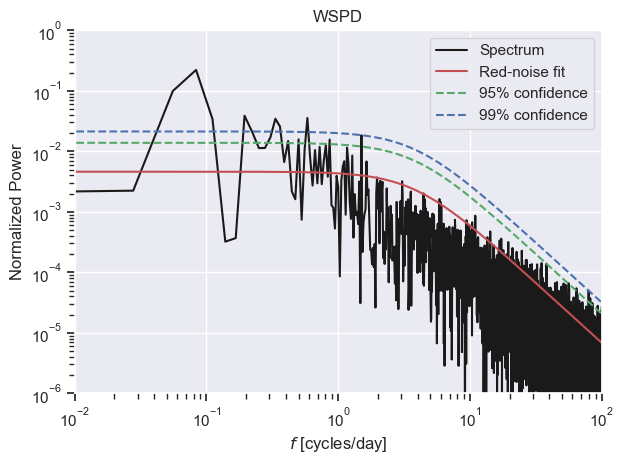

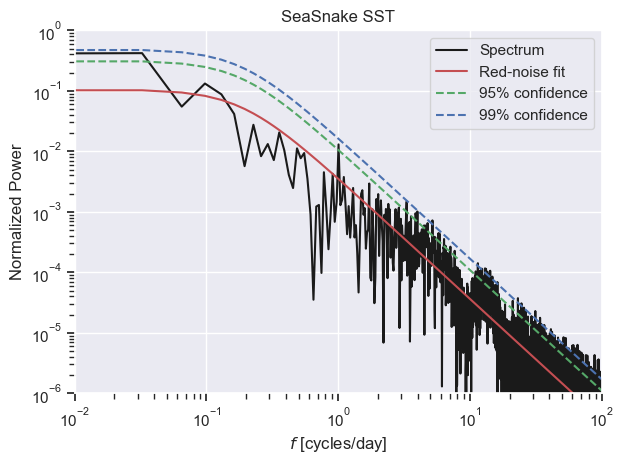

In [7]:
plot_power_spec(dship['wspd'], time_step=1/(24*60), title='WSPD')
plot_power_spec(np.array(snakedat[4]), time_step=1/(24*60), title='SeaSnake SST')

#### Time series

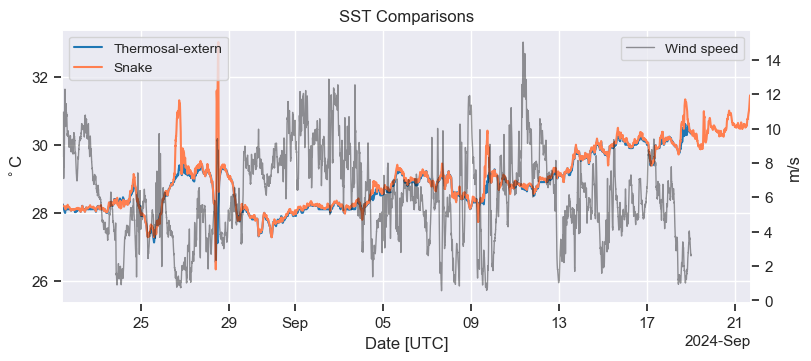

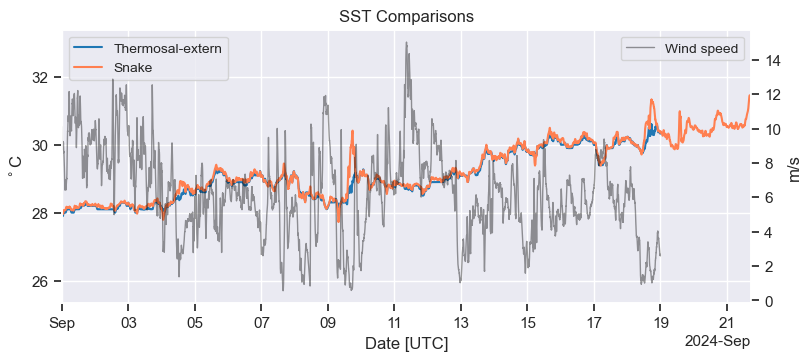

In [8]:
xlim = (snakedat[0].iloc[0], snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), np.datetime64('2024-08-27T12'))

figdata = {
    'fig_title': 'SST Comparisons',
    'snake_sst': snakedat[4],
    'time_snake': snakedat[0],
    'units_sst': r'$^\circ$C',
    # 'station_sst': sst1-273.15,
    'thermo_sst': dship['sst1']-273.15,
    'wspd': dship['wspd'],
    'units_var2': 'm/s',
    'time_dship': dship['time'],
    # 'units2': r'$^\circ$C',
    'xlim': xlim,
           }

plot_time_series(figdata)

# xlim = (np.datetime64('2024-09-03T00'), snakedat[0].iloc[-1])
xlim = (np.datetime64('2024-09-10T00'), snakedat[0].iloc[-1])
xlim = (np.datetime64('2024-09-10T00'), np.datetime64('2024-09-16T00'))
xlim = (np.datetime64('2024-09-01T00'), np.datetime64('2024-09-09T00'))
xlim = (np.datetime64('2024-09-01T00'), snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-09-06T00'), np.datetime64('2024-09-12T00'))
figdata['xlim']=xlim
plot_time_series(figdata)

#### Daily-smoothing check

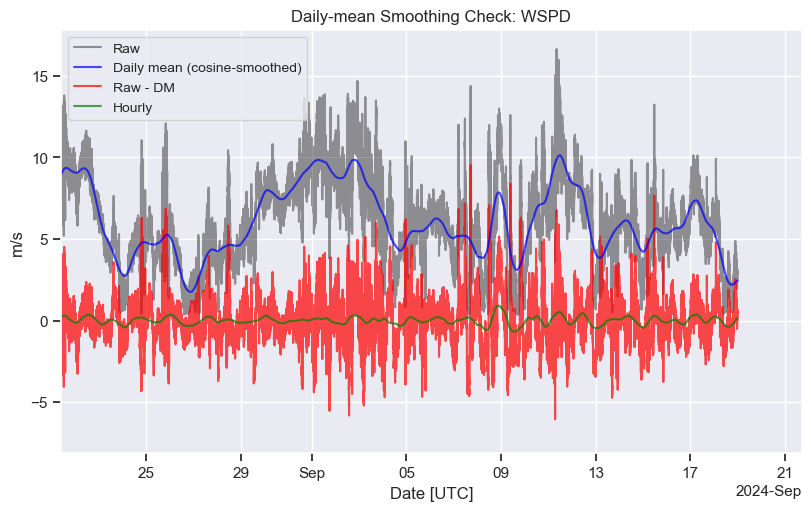

In [9]:
xlim = (snakedat[0].iloc[0], snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), np.datetime64('2024-08-27T12'))

time = np.copy(dship['time'])

wspd0 = np.copy(dship['wspd'])

h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
dt = (time[1] - time[0]).astype('timedelta64[ns]')
npd = int(np.round(h24 / dt))

hon1 = np.timedelta64(1, 'h').astype('timedelta64[ns]')
dt = (time[1] - time[0]).astype('timedelta64[ns]')
nphr = int(np.round(h24 / dt))

wspd_df = pd.DataFrame(wspd0)

# wspd1 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2)).mean())
wspd2_df = wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
                                          win_type='cosine').mean()
wspd2 = np.squeeze(wspd2_df)
wspd3 = np.squeeze((wspd_df - wspd2_df).rolling(window=nphr, center=True, closed='both', min_periods=int(npd*0.2),
                                          win_type='cosine').mean())
# wspd3 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
#                                           win_type='gaussian').mean(std=npd))
# wspd4 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
#                                           win_type='exponential').mean())
# wspd5 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
#                                           win_type='boxcar').mean())

########################################################

fig_x = 8
fig_y = 5
fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

ax.set_title('Daily-mean Smoothing Check: WSPD')

ax.set_ylabel('m/s')
ax.set_xlabel('Date [UTC]')
ax.set_xlim(xlim)

ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

linewidth=1.5

ax.plot(time, wspd0, label='Raw', color='black', linewidth=linewidth, alpha=0.4, zorder=1)

# linewidth=1

# ax.plot(time, wspd1, label='Boxcar', color='red', linewidth=linewidth*2, alpha=0.7, zorder=2)
ax.plot(time, wspd2, label='Daily mean (cosine-smoothed)', color='blue', linewidth=linewidth, alpha=0.7, zorder=2)
ax.plot(time, wspd0-wspd2, label='Raw - DM', color='red', linewidth=linewidth, alpha=0.7, zorder=1)
ax.plot(time, wspd3, label='Hourly', color='green', linewidth=linewidth, alpha=0.7, zorder=1)
# ax.plot(time, wspd4, label='Exponential', color='green', linewidth=linewidth, alpha=1, zorder=3)
# ax.plot(time, wspd5, label='Boxcar2', color='green', linewidth=linewidth, alpha=1, zorder=3)

ax.legend(fontsize=10, loc='upper left')#frameon=False)

# Time labels
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.show()
plt.close()

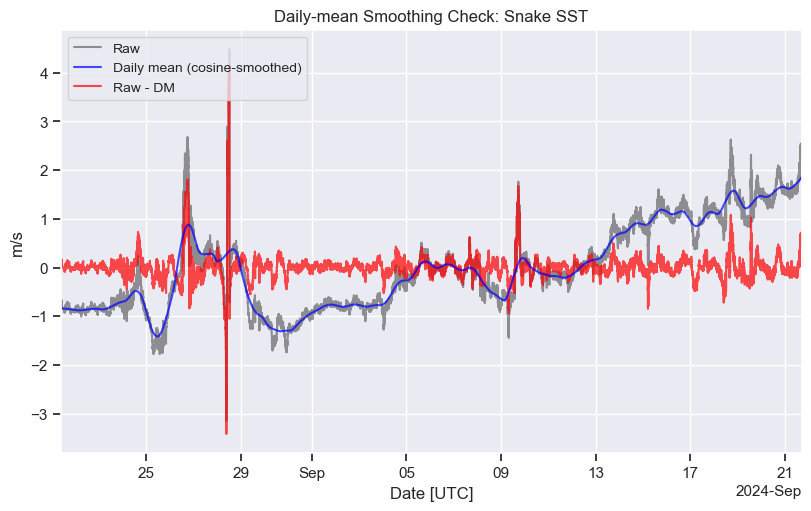

In [10]:
xlim = (snakedat[0].iloc[0], snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), np.datetime64('2024-08-27T12'))

time = np.copy(snakedat[0])

sst0 = np.copy(snakedat[4])

h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
dt = (time[1] - time[0]).astype('timedelta64[ns]')
npd = int(np.round(h24 / dt))

sst_df = pd.DataFrame(sst0)

sst2 = np.squeeze(sst_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
                                          win_type='cosine').mean())

########################################################

fig_x = 8
fig_y = 5
fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

ax.set_title('Daily-mean Smoothing Check: Snake SST')

ax.set_ylabel('m/s')
ax.set_xlabel('Date [UTC]')
ax.set_xlim(xlim)

ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

linewidth=1.5

ax.plot(time, sst0 - np.nanmean(sst0), label='Raw', color='black', linewidth=linewidth, alpha=0.4, zorder=1)

# linewidth=1

ax.plot(time, sst2 - np.nanmean(sst0), label='Daily mean (cosine-smoothed)', color='blue', linewidth=linewidth, alpha=0.7, zorder=2)
ax.plot(time, sst0-sst2, label='Raw - DM', color='red', linewidth=linewidth, alpha=0.7, zorder=1)

ax.legend(fontsize=10, loc='upper left')#frameon=False)

# Time labels
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.show()
plt.close()

#### Test of different smoothing windows

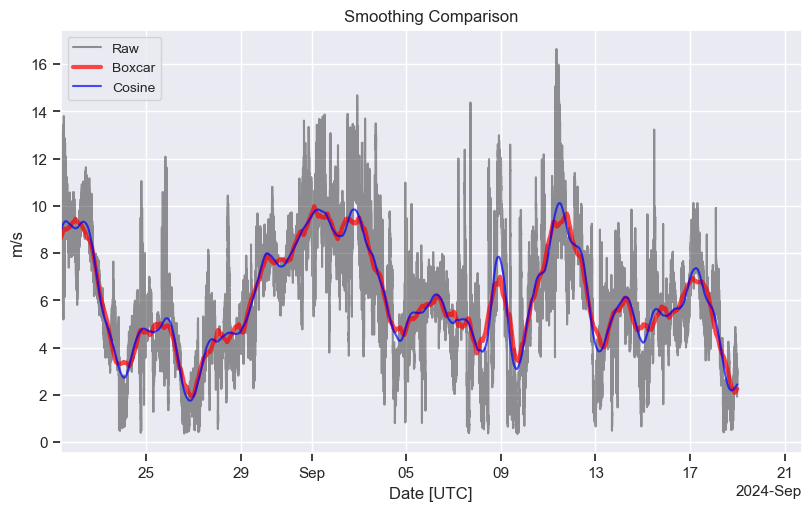

In [11]:
xlim = (snakedat[0].iloc[0], snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), snakedat[0].iloc[-1])
# xlim = (np.datetime64('2024-08-24T00'), np.datetime64('2024-08-27T12'))

time = np.copy(dship['time'])

wspd0 = np.copy(dship['wspd'])

h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
dt = (time[1] - time[0]).astype('timedelta64[ns]')
npd = int(np.round(h24 / dt))

wspd_df = pd.DataFrame(wspd0)

wspd1 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2)).mean())
wspd2 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
                                          win_type='cosine').mean())
# wspd3 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
#                                           win_type='gaussian').mean(std=npd))
# wspd4 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
#                                           win_type='exponential').mean())
wspd5 = np.squeeze(wspd_df.rolling(window=npd, center=True, closed='both', min_periods=int(npd*0.2),
                                          win_type='boxcar').mean())

########################################################

fig_x = 8
fig_y = 5
fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

ax.set_title('Smoothing Comparison')

ax.set_ylabel('m/s')
ax.set_xlabel('Date [UTC]')
ax.set_xlim(xlim)

ax.grid(True, axis='x')#, color='0.55', linewidth=0.5)
ax.grid(True, axis='y')#, color='0.55', linewidth=0.5)

linewidth=1.5

ax.plot(time, wspd0, label='Raw', color='black', linewidth=linewidth, alpha=0.4, zorder=1)

# linewidth=1

ax.plot(time, wspd1, label='Boxcar', color='red', linewidth=linewidth*2, alpha=0.7, zorder=2)
ax.plot(time, wspd2, label='Cosine', color='blue', linewidth=linewidth, alpha=0.7, zorder=2)
# ax.plot(time, wspd3, label='Gaussian', color='green', linewidth=linewidth, alpha=1, zorder=3)
# ax.plot(time, wspd4, label='Exponential', color='green', linewidth=linewidth, alpha=1, zorder=3)
# ax.plot(time, wspd5, label='Boxcar2', color='green', linewidth=linewidth, alpha=1, zorder=3)

ax.legend(fontsize=10, loc='upper left')#frameon=False)

# Time labels
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

plt.show()
plt.close()

### Diurnal composites

#### Plot and processing functions

In [12]:
def simplify_time(invar_0, times_invar_0, dt):

    # Puts variable onto a regular time grid, with NaNs for potential
    # gaps at start and end of array.
    # 
    # CAUTION: if there are gaps in the middle of the time series,
    # they will be filled using this function.
    # 
    # times_invar_0 should be a datetime64 array
    # 
    # dt is time step size as a timedelta64

    invar = np.array(invar_0)
    times_invar = np.array(times_invar_0, dtype='datetime64[ns]')

    # Use timedeltas to determine N steps per day (npd)
    # ...being sure to use consistent timedelta units, i.e., [ns]
    h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')

    t0 = times_invar[0].astype('datetime64[D]')
    t1 = times_invar[-1].astype('datetime64[D]')
    times_new = np.arange(t0, t1+h24, dt, dtype='datetime64[ns]')

    invar_interp = np.interp(times_new.astype(np.float64), times_invar.astype(np.float64), invar)

    # Set any extrapolated values at the ends of the series to NaN
    invar_interp[np.where(times_new < times_invar[0])] = np.nan
    invar_interp[np.where(times_new > times_invar[-1])] = np.nan

    return invar_interp, times_new

In [13]:
# Calculate diurnal composite
def diurnal_composite(invar_0, times_invar_0, dt, days=None, standardize=False):#, anom=False):

    # times_invar_0 should be a datetime64 array
    # 
    # dt is time step size as a timedelta64
    # 
    # 'days' should be an array of days to include, at their respective 00:00 H
    # in dtype datetime64[ns].

    invar_1 = np.copy(invar_0)
    # times_invar = np.copy(times_invar_0)

    # Standardize?
    if standardize:
        invar_1 = (invar_1 - np.nanmean(invar_1)) / np.nanstd(invar_1)

    # Remove daily mean using running mean
    # if anom:
    invar_1 = invar_1 - dailyavg(invar_1, times_invar_0)

    # Simplify time
    invar_2, times_invar = simplify_time(invar_1, times_invar_0, dt)

    # Use timedeltas to determine N steps per day (npd)
    # ...being sure to use consistent timedelta units, i.e., [ns]
    h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
    dt = (times_invar[1] - times_invar[0]).astype('timedelta64[ns]')
    npd = int(np.round(h24 / dt))

    nd = int(invar_2.shape[0]/npd)
    dc_indices=np.arange(nd)*npd

    t0 = times_invar[0].astype('datetime64[D]')
    t1 = times_invar[-1].astype('datetime64[D]')
    days_check = np.arange(t0, t1+h24, h24, dtype='datetime64[ns]')
    if days is None:
        days = days_check
    else:
        # Ensure that the provided days don't exceed actual data bounds
        days = days[np.where((days >= t0) & (days <= t1))]
    nd=days.size

    invar_select = np.zeros((nd, npd))
    for iday in range(nd):
        ind_select = np.where((times_invar >= days[iday]) & (times_invar < days[iday]+h24))
        invar_select[iday,:] = invar_2[ind_select]

    # Average across days
    var_dc = np.nanmean(invar_select, axis=0)

    # Standardize?
    if standardize:
        var_dc = (var_dc - np.nanmean(var_dc)) / np.nanstd(var_dc)

    # Repeat diurnal cycle in time
    var_dc = np.concatenate((var_dc, var_dc, var_dc[0:1]))

    return var_dc

In [14]:
def plot_diurnal_composite(figdata):

    def dc_smooth(invar, nt_smooth=10):
        # Copy ends to make smoothing periodic
        invar_long = np.concatenate((invar[-nt_smooth:], invar, invar[:nt_smooth]))
        invar_df = pd.DataFrame(invar_long)
        invar_smoothed = invar_df.rolling(window=nt_smooth, center=True, closed='both', min_periods=int(nt_smooth/2),
                                          win_type='cosine').mean()
        return np.squeeze(invar_smoothed[nt_smooth:-nt_smooth])

    fig_x = 8
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_xlabel('Hour [UTC]')
    plt.xticks(np.arange(0,49,6))

    xdim = np.arange(figdata['npd']*2+1)*24/npd

    linewidth=1.6
    alpha=1.
    color1='#ff7f50'
    color2='black'

    ax.set_ylabel(figdata['units1'])
    nt_smooth = 60
    pvar1_sm = dc_smooth(figdata['pltvar1'], nt_smooth=nt_smooth)
    # ax.plot(xdim, figdata['pltvar1'], linewidth=linewidth, color=color1, label=figdata['label1'], alpha=alpha)
    ax.plot(xdim, pvar1_sm, linewidth=linewidth, color=color1, label=figdata['label1'], alpha=alpha)
    ax.plot(xdim, figdata['pltvar2']*np.nan, linewidth=linewidth, color=color2, label=figdata['label2'], alpha=0.4)

    ax.grid(True, axis='x')
    ax.grid(True, axis='y')

    plt.legend()

    # Second axis

    ax2 = ax.twinx()
    ax2.set_ylabel(figdata['units2'])
    pvar2_sm = dc_smooth(figdata['pltvar2'], nt_smooth=nt_smooth)
    # ax2.plot(xdim, figdata['pltvar2'], linewidth=linewidth, color=color2, label=figdata['label2'], alpha=0.4)
    ax2.plot(xdim, pvar2_sm, linewidth=linewidth, color=color2, label=figdata['label2'], alpha=0.4)

    ax2.grid(False, axis='x')
    ax2.grid(False, axis='y')

    plt.show()
    plt.close()
    return

#### Run plots

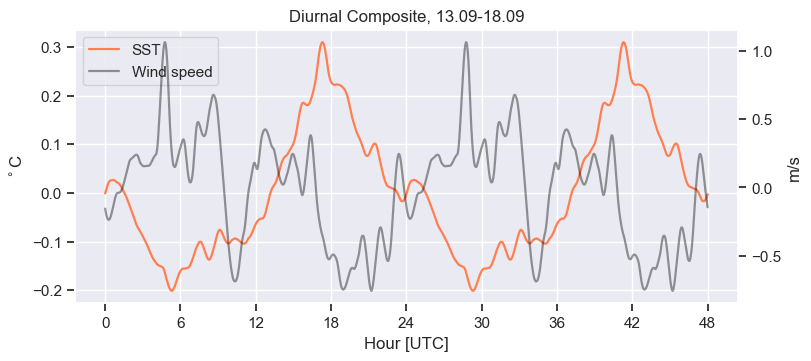

In [15]:
dt = np.timedelta64(1, 'm')
h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
npd = int(np.round(h24 / dt))

# t0 = np.datetime64('2024-09-01T00:00')
t0 = np.datetime64('2024-09-13T00:00')
t1 = np.datetime64('2024-09-18T00:00')
# t0 = np.datetime64('2024-09-04T00:00')
# t1 = np.datetime64('2024-09-08T00:00')
days = np.arange(t0, t1+h24, h24, dtype='datetime64[ns]')

t0str = np.datetime_as_string(t0)
t1str = np.datetime_as_string(t1)
date_str = t0str[8:10]+'.'+t0str[5:7]+'-'+t1str[8:10]+'.'+t1str[5:7]

figdata = {
    'fig_title': 'Diurnal Composite, '+date_str,
    'pltvar1': diurnal_composite(np.array(snakedat[4]), np.array(snakedat[0]), dt, days=days),
    'pltvar2': diurnal_composite(dship['wspd'], dship['time'], dt, days=days),
    'units1': r'$^\circ$C',
    'units2': 'm/s',
    'label1': 'SST',
    'label2': 'Wind speed',
    'npd': npd,
    }

plot_diurnal_composite(figdata)

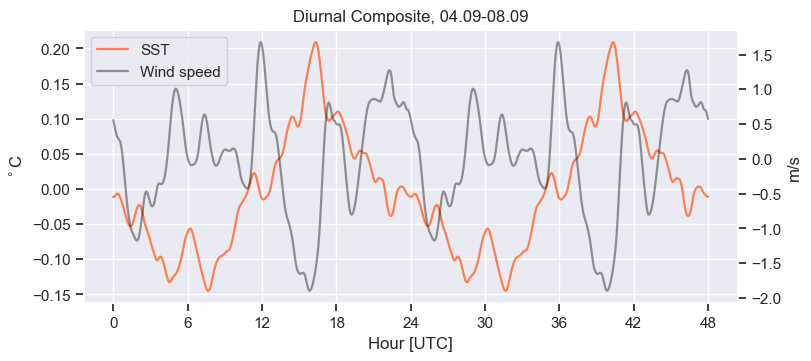

In [16]:
dt = np.timedelta64(1, 'm')
h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
npd = int(np.round(h24 / dt))

# t0 = np.datetime64('2024-09-01T00:00')
# t0 = np.datetime64('2024-09-13T00:00')
# t1 = np.datetime64('2024-09-18T00:00')
t0 = np.datetime64('2024-09-04T00:00')
t1 = np.datetime64('2024-09-08T00:00')
days = np.arange(t0, t1+h24, h24, dtype='datetime64[ns]')

t0str = np.datetime_as_string(t0)
t1str = np.datetime_as_string(t1)
date_str = t0str[8:10]+'.'+t0str[5:7]+'-'+t1str[8:10]+'.'+t1str[5:7]

figdata = {
    'fig_title': 'Diurnal Composite, '+date_str,
    'pltvar1': diurnal_composite(np.array(snakedat[4]), np.array(snakedat[0]), dt, days=days),
    'pltvar2': diurnal_composite(dship['wspd'], dship['time'], dt, days=days),
    'units1': r'$^\circ$C',
    'units2': 'm/s',
    'label1': 'SST',
    'label2': 'Wind speed',
    'npd': npd,
    }

plot_diurnal_composite(figdata)